In [150]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
import tensorflow_probability as tfp
import random

import gym
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

#Hyperparameters
learning_rate = 5e-4
gamma         = 1
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3
T_horizon     = 20

losses = []
class PPO(Model):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []
        self.fc1   = layers.Dense(64, activation='relu')#, kernel_initializer='he_uniform')
        self.fc_pi = layers.Dense(2, activation='softmax')#, kernel_initializer='he_uniform')
        self.fc_v  = layers.Dense(1, activation=None)#,kernel_initializer='he_uniform')
        self.optimizer = tf.keras.optimizers.Adam(lr=learning_rate)#, amsgrad=True)
        
    def pi(self, x):
        x = self.fc1(x)
        prob = self.fc_pi(x)
        return prob
    
    def v(self, x):
        x = self.fc1(x)
        v = self.fc_v(x)
        return v
      
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition
            
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            done_mask = 0 if done else 1
            done_lst.append([done_mask])
            
        s = tf.convert_to_tensor(s_lst,dtype=tf.float32)
        a = tf.convert_to_tensor(a_lst,dtype=tf.int32)
        r = tf.convert_to_tensor(r_lst,dtype=tf.float32)
        s_prime = tf.convert_to_tensor(s_prime_lst,dtype=tf.float32)
        done_mask = tf.convert_to_tensor(done_lst,dtype=tf.float32)
        prob_a = tf.convert_to_tensor(prob_a_lst,dtype=tf.float32)

        self.data = []
        return s, a, r, s_prime, done_mask, prob_a
        
    def train_net(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch()
        for i in range(K_epoch):
            td_target = r + gamma * self.v(s_prime) * done_mask
            delta = td_target - self.v(s)
            delta = delta.numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = tf.convert_to_tensor(advantage_lst, dtype=tf.float32)
            
            with tf.GradientTape() as tape:
                pi = self.pi(s)
                idx = tf.stack([tf.range(tf.shape(a)[0]),a[:,0]],axis=-1)
                pi_a = tf.gather_nd(pi,idx)[:,None]
                ratio = tf.math.exp(tf.math.log(pi_a) - tf.math.log(prob_a)) 
                surr1 = ratio * advantage
                surr2 = tf.clip_by_value(ratio, 1-eps_clip, 1+eps_clip) * advantage
                actor_loss = tf.minimum(surr1,surr2)
                critic_loss_fn = tf.keras.losses.MeanSquaredError()
                critic_loss = critic_loss_fn(td_target, self.v(s))
                loss = -actor_loss + critic_loss
                loss = tf.reduce_mean(loss)
                gradients = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients,self.trainable_weights))
            losses.append(loss.numpy())

In [151]:
scores_deque = deque(maxlen=100) 
scores_mean = []
env = gym.make('CartPole-v1')
model = PPO()

for n_epi in range(500):
    s = env.reset()
    done = False
    score = 0
    while not done:
        for t in range(T_horizon):
            prob = model.pi(tf.convert_to_tensor(s,dtype=tf.float32)[None,:])
            m = tfp.distributions.Categorical(prob)
            a = m.sample().numpy()[0]
            s_prime, r, done, info = env.step(a)
            score+=r
            model.put_data((s, a, r/100, s_prime, prob[0,a].numpy(), done))
            s = s_prime

            if done:
                break

        model.train_net()
    scores_deque.append(score)
    scores_mean.append(np.mean(scores_deque))

    if n_epi%100==0 and n_epi!=0:
        print(f'Episode {n_epi}: mean average score at {scores_mean[-1]}')
    if scores_mean[-1] > 150: 
        print(f'Solved at {n_epi} {scores_mean[-1]}')
        break

env.close()

Episode 100: mean average score at 24.58
Episode 200: mean average score at 42.06
Episode 300: mean average score at 76.52
Episode 400: mean average score at 101.35


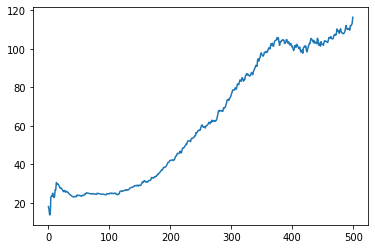

In [152]:
plt.plot(scores_mean)

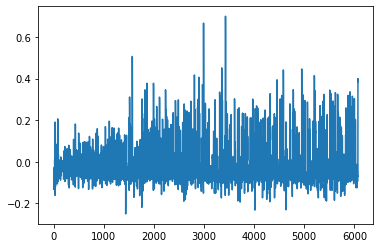

In [153]:
plt.plot(losses)